# Visualizing participant networks

This notebook is designed to help interpretation of the roles of participants in a network. If the role cannot be directly be derived from the structure of the network but depends on the quality of actual interactions, we need to be able to extract information on the interactions and agency levels invested in these interactions.

This notebook, therefore, contains a number of diverse functions that help visualizing and sorting interactions in order to assist interpreting the roles of the participants.

In [1]:
import collections
import pandas as pd
import numpy as np
import networkx as nx
import forceatlas2
import random

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

Network data

In [2]:
data = pd.read_excel('Lev17-26.edges.Static.xlsx')

## Participants and clusters

In [3]:
G = nx.MultiDiGraph()
for n, row in data.iterrows():
    if row['Source'] != row['Target']: #Ignoring selfloops, e,g., "YHWH" > "YHWH"
        G.add_edge(row.Source, row.Target, value=row.Label)

#### Who has most relationships?

In [4]:
rel_dict = {}

for n in G.nodes():
    rel_dict[n] = len(nx.ego_graph(G, n, undirected=True))-1
    
pd.DataFrame([rel_dict]).T.sort_values(by=0, ascending=False)

,0
2MSg,27
Israelites,26
an_Israelite,21
sojourner,19
YHWH,15
Aaron,13
Aaron's_sons,9
brother,7
Moses,6
father,5


In [5]:
a = nx.ego_graph(G1, 'sojourner', undirected=True)
b = nx.ego_graph(G1, 'Israelites', undirected=True)
for n in a.nodes():
    if n not in b.nodes():
        print(n)

NameError: name 'G1' is not defined

#### Which clusters of participants do the relations belong to?

In [6]:
clusters = pd.read_csv('node2vec/multiple_directed_valued_clusters.csv', index_col=0)
clusters.sort_values(by='cluster', ascending=False)

,cluster
Aaron's_sons,2
Israelites,2
an_Israelite,2
Aaron,2
sojourner,2
2msg,2
YHWH,2
group_of_people,1
daughter,1
fellow's_wife,1


We can get the cluster to which each participant belong and thus see the membership of those participant to which an ego is connected:

In [7]:
def getGroups(G, ego, clusters=clusters):
    
    cluster_dict = {}
    
    ego_graph = nx.ego_graph(G, ego, undirected=True)
    for r in list(ego_graph.nodes()):
        cluster_dict[r] = clusters[clusters.index == r].cluster.item()
    
    df = pd.DataFrame([cluster_dict]).T.sort_values(by=0, ascending=False)
    df = df[df.index != ego]
    return df

getGroups(G, 'Israelites')

,0
YHWH,2
Aaron,2
sojourner,2
Aaron's_sons,2
an_Israelite,2
foreign_nations,1
blasphemer,1
sister,1
remnants,1
Moses,1


Which participant has connections to most core participants?

In [8]:
for actor in list(G.nodes()):
    groups = getGroups(G, actor)
    
    print(actor, len(groups[groups[0] == 2]))
    

ValueError: can only convert an array of size 1 to a Python scalar

## Draw egonetworks

In [9]:
def draw_ego(graph, actor, size=(10,10), data=data, save=False, bw=False):    
    plt.figure(figsize = size)

    ego = nx.ego_graph(graph, actor, undirected=True, radius=1)
    
    #Print edge labels
    edge_labels = collections.defaultdict(set)
    
    for e in ego.edges(data='value'):
        edge_labels[(e[0],e[1])].add(e[2])
        
    for e in edge_labels:
        print('''{0:30}{1:30}'''.format(' -> '.join(e), ', '.join(edge_labels[e])))

    pos=nx.spring_layout(ego)
    nx.draw(
        ego,
        pos=pos,
        with_labels=True,
        edge_color='grey',
        node_color='lightgrey' if bw else 'lightblue',
        node_size=[n[1]*10 for n in ego.degree()],
        font_size=14
        )
    nx.draw_networkx_nodes(ego, pos=pos, nodelist=[actor], node_color='lightgrey' if bw else 'salmon', node_size=ego.degree(actor)*10)
    plt.margins(x=0.1, y=0.1)
    if save:
        plt.savefig(fname=f'images/{save}.png', dpi=500)
    plt.show()

blasphemer -> YHWH            bore                          
blasphemer -> Israelites      go out                        
Moses -> Israelites           command, speak, say           
Moses -> blasphemer           go out                        
Israelites -> blasphemer      go out, stone                 
Israelites -> Moses           take                          
Israelites -> YHWH            be high, slaughter, swear, approach, give, abhor, defile, walk, be holy, hear, rejoice, come, admonish
YHWH -> Moses                 speak, command, say           
YHWH -> Israelites            be empty, send, separate, walk, miss, be holy, be fertile, say, sit, command, be many, give, scatter, go out, turn, make, come, strike, arise, add, break, admonish
witnesses -> Moses            come                          
witnesses -> blasphemer       settle, come, support         


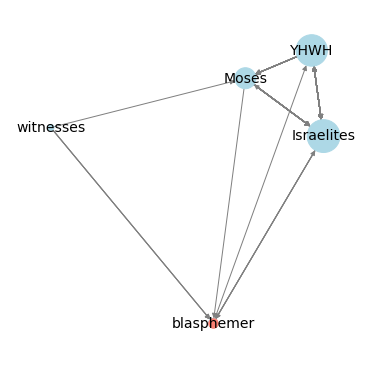

In [10]:
draw_ego(G, "blasphemer", size=(5,5), save='7.24a')

## Node removal and cohesion

We can measure the structural importance of a participant by performing a 'removal test'. A removal test computes the resulting density of the network when removing a participant. The participant which causes the largest loss of network density by its removal is the structurally most important participant. 

In [11]:
len(nx.ego_graph(G, 'sojourner', undirected=True, radius=1).nodes)

20

In [12]:
def removalTest(ego):
    
    density_dict = {}
    for n in ego.nodes():
        remove = [l for l in ego.nodes() if l!=n]
        new_graph = ego.subgraph(remove)
        density_dict[n] = nx.density(new_graph)

    removal_df = pd.DataFrame([density_dict]).T
    removal_df.columns=['density']
    return removal_df

#removalTest(G)

Original density of egonetwork: 4.333333333333333


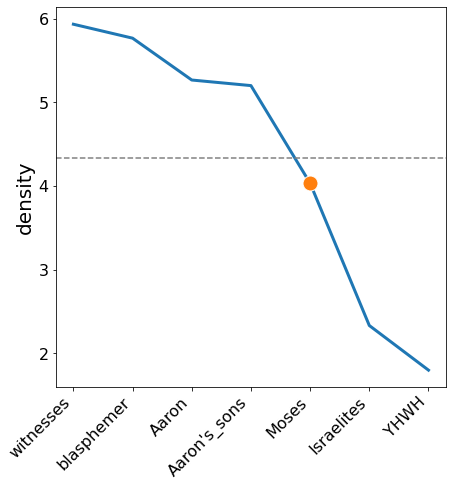

In [13]:
def plotDF(graph, column, actor=str(), typ='ego', plot_graph=False, line=True, save=str()):
    '''
    It is possible to make a removal test for an ego-network (type='ego') and the entire graph ('graph')
    '''

    if typ == 'ego':
        ego = nx.ego_graph(graph, actor, undirected=True)
        df = removalTest(ego)
        df = df.sort_values(by=column, ascending=False).tail(15)
        ego_index = df.index.get_loc(actor)
        density = nx.density(ego)
        print(f'Original density of egonetwork: {density}')
 
    elif typ == 'graph':
        df = removalTest(graph)
        df = df.sort_values(by=column, ascending=False).tail(15)
        density = nx.density(graph)
        print(f'Original density of network: {density}')
    
    fig, ax = plt.subplots(figsize=(len(df),7))
    plot = plt.plot(df.index, df[column], linewidth=3)
    if actor:
        actor_x = df.index.get_loc(actor)
        actor_y = df[df.index == actor].density.item()
        plt.plot([actor_x], [actor_y], marker="o", markeredgecolor="white", markersize=15)
    plt.ylabel("density", size=20)
    plt.xticks(size=16, rotation=45, ha='right')
    plt.yticks(size=16)
    
    if line:
        plt.axhline(y=density, linestyle='dashed', color='grey')
    
    # draw graph in inset
    if plot_graph:
        plt.axes([0.4, 0.4, 0.5, 0.5])
        nodes = list(df.index)

        subgraph = graph.subgraph(nodes)
        pos = nx.spring_layout(subgraph)
        nx.draw(
            subgraph,
            pos=pos,
            with_labels=True,
            edge_color='grey',
            node_color='lightblue',
            font_size=14
            )
        nx.draw_networkx_nodes(subgraph, pos=pos, nodelist=[ego], node_color='salmon')

        plt.axis('off')
        
    if save:   
        plt.savefig(f'images/{save}', bbox_inches='tight', dpi=500)

plotDF(G, actor="Moses", column='density', typ='ego', line=True)

In [ ]:
plotDF(G, column='density', typ='graph', line=True, save='7.13.png')

### Agency and roles

By importing the participant data of Leviticus 17-26 we get additional means to show the participants and their networks.

In [ ]:
from tf.app import use
A = use('etcbc/bhsa', version='c', hoist=globals(), mod='ch-jensen/participants/actor/tf')

In [ ]:
plotDF(G, actor="Moses", column='density', typ='ego', line=True)

#### Roles

We can calculate the mean agency invested by a participant in each of its relationships. This provides a simple visualization of its role in all its relationships.

In [ ]:
def Roles(actor, data=data, width=int(), bw=False, save=False):
    
    agency = []
    df = data[(data.Source == actor) | (data.Target == actor)]
    
    for n, row in df.iterrows():
        if row.Source == actor:
            agency.append((row.Target,row.Source_agency))
        else:
            agency.append((row.Source,row.Target_agency))

    new_df = pd.DataFrame(agency)
    new_df.columns = ['participant', 'agency']

    mean = new_df.groupby('participant')['agency'].mean().sort_values()
    mean_df = pd.DataFrame(mean)
    print(f'Mean agency of {actor}: {round(new_df.agency.mean(), 3)}')
    
    custom_palette = {}
    for n, row in mean_df.iterrows():
        if row.agency < -1:
            custom_palette[n] = "#d9dddc" if bw else "#E50600" 
        elif row.agency >= -1 and row.agency < 0:
            custom_palette[n] = "#d0d4d4" if bw else "#ED5955"
        elif row.agency >= 0 and row.agency < 1:
            custom_palette[n] = "#c7cbcb" if bw else "#D2E3F0" 
        elif row.agency >= 1 and row.agency < 2:
            custom_palette[n] = "#bdc3c2" if bw else "#A5C8E1"
        elif row.agency >= 2 and row.agency < 3:
            custom_palette[n] = "#b4bab9" if bw else "#78ADD2"
        elif row.agency >= 3 and row.agency < 4:
            custom_palette[n] = "#aab2b1" if bw else "#4B92C3"
        elif row.agency >= 4:
            custom_palette[n] = "#a1a9a8" if bw else "#1f77b4"
            
    g= sns.catplot(x='participant', y='agency', kind='bar', order=mean.index, data=new_df, palette=custom_palette)
    g.fig.set_size_inches(len(mean_df)*width,5)
    plt.ylabel('mean agency', size=20)
    plt.xlabel('')
    plt.yticks(size=16)
    plt.xticks(size=16, rotation=45, ha='right')
    
    if save:
        plt.savefig(fname=f'images/{save}.png', dpi=500, bbox_inches='tight')

    plt.show()

Roles('2MSg', width=0.6, save='7.16')

In [ ]:
Roles('father', width=0.7, save='7.26')

#### Show interactions

We can also show can also show specific interactions between two participants:

In [ ]:
def show(Actor, Undergoer, verb=list(), data=data):
    
    clauses = []
    
    if verb:
        clauses = data[(data.Source == Actor) & (data.Target == Undergoer) & (data.Label.isin(verb))].Clause
    else:
        clauses = data[(data.Source == Actor) & (data.Target == Undergoer)].Clause
    
    if clauses.any():
        
        #Write clause references
        clause_list = list(set(clauses))
        clause_list.sort()
        
        ref_string = '''{} {}:{}'''.format(*T.sectionFromNode(clause_list[0]))
        for cl in clause_list[1:]:
            bo, ch, ve = T.sectionFromNode(cl)
            
            prec_cl = clause_list.index(cl)-1
            prec_bo, prec_ch, prec_ve = T.sectionFromNode(clause_list[prec_cl])
            if ch == prec_ch and ve == prec_ve:
                if '×' in ref_string[-3]:
                    indices = (ref_string.rindex('×'), ref_string.rindex(')'))
                    existing_value = ref_string[indices[0]+1:indices[1]]
                    new_value = str(int(existing_value)+1)
                    ref_string = ref_string[:indices[0]+1] + new_value + ref_string[indices[0]+len(new_value)+1:]
                else:
                    ref_string += f' (×2)'
            elif ch == prec_ch:
                ref_string += f', {ve}'
            else:
                ref_string += f'; {ch}:{ve}'
                    
        print(f'{ref_string}.')
        
        #Display clauses
        for cl in clause_list:
            A.pretty(cl)
            
    else:
        return "No relevant clauses to return"

In [ ]:
show("2msg","poor")

In [ ]:
show("sojourner","brother")

### Case-study: The women

We can make specific casestudies of particular participants by collapsing the participants into group. In this case, we collapse all women of the network into one participants in order to see more general trends.

In [ ]:
def contractNodes(G, new_label, nodes_to_contract):
    
    for n in nodes_to_contract[1:]: #Contract nodes with the first node of the list
        G = nx.contracted_nodes(G, nodes_to_contract[0], n)
        
    G = nx.relabel_nodes(G, {nodes_to_contract[0]: new_label}, copy=True)
    
    return G

In [ ]:
contract_women = ['mother','virgin','widowed/expelled/defiled_woman', 'handmaid',"father's_wife",'aunt', 'aunt-in-law',
                  'daughter-in-law', 'granddaughter','woman_and_her_mother','man/woman', 'woman_in_menstruation','relative',
                  'woman','woman_and_her_daughter','granddaughter_of_woman','sister_of_woman','sister',"fellow's_wife",
                  'daughter']

G_women = contractNodes(G, 'women', contract_women)

data_women = data.replace(contract_women, 'women')

In [ ]:
draw_ego(G_women, 'sojourner')

In [ ]:
Roles('women', data_women, save='7.25')

In [ ]:
show('women',"kinsmen", data=data_women)

In [ ]:
show("2msg",'women', data=data_women)

### Case-study: The poor, the blind, the deaf, and the elderly

In [ ]:
contract_marg = ['poor','deaf','blind','elderly']

G_marginalized = contractNodes(G, 'marginalized', contract_marg)

data_marginalized = data.replace(contract_marg, 'marginalized')

In [ ]:
Roles('2ms')

In [ ]:
show('2ms','elderly')

In [ ]:
show('2ms','marginalized', data=data_marginalized)

### Case-study: The priests

In [ ]:
G = nx.MultiDiGraph()
for n, row in data.iterrows():
    G.add_edge(row.Source, row.Target, value=row.Label)

In [ ]:
G_priests = nx.contracted_nodes(G, "Aaron's_sons", "Aaron")
G_priests = nx.relabel_nodes(G_priests, {"Aaron's_sons":'priests'}, copy=True)

In [ ]:
data_priests = data.replace(['Aaron',"Aaron's_sons"], 'priests')

In [ ]:
plotDF(G_priests, actor="priests", column='density', typ='ego', line=True, save='7.19.png')

In [ ]:
Roles('priests',data_priests, save='7.20')

In [ ]:
show('lay-person', 'priests', data=data_priests)

In [ ]:
show('priests', 'YHWH', data=data_priests)

### Case-study: The sojourner

The sojourner is a curious participant in the network. On the hand, Leviticus 17-26 gives the impression that the sojourner is generally a person on the margins of society. However, in the network, he is situated safely at the core of the network. The network may be misleading because the native Israelites are distinguished as the collective group ("Israelites"), an individual Israelite addressee ("2ms") and an individual, third-person Israelite ("an_Israelite"). Of course, many other participants (e.g. the mother and the father) also belong to the Israelites as an ethnic category. In the text, however, they are not so much distinguished in terms of ethnicitiy as in terms of social role. Therefore, these other roles will be retained. The first three, however, will be merged into a single role in order to explore the role of the sojourner in contrast to Israelites:

In [ ]:
G = nx.MultiDiGraph()
for n, row in data.iterrows():
    G.add_edge(row.Source, row.Target, value=row.Label)

In [ ]:
G1 = nx.contracted_nodes(G, "Israelites", "2MSg")
G1 = nx.contracted_nodes(G1, "Israelites", "an_Israelite")

In [ ]:
draw_ego(G1, "Israelites")

We want to contrast the sojourner and the Israelites. First, we query whether the sojourner has connections which the Israelites do not have:

In [ ]:
def getEdgeLabels(graph, ego):
    
    ego_graph = nx.ego_graph(graph, ego, undirected=True)

    #get edge labels
    edge_labels = collections.defaultdict(set)
    for e in ego_graph.edges(data='value'):
        edge_labels[(e[0],e[1])].add(e[2])

    return edge_labels

def contrastConnections(graph, ego, alter):
    
    edge_labels = getEdgeLabels(graph, ego)

    differences = []
    for e in edge_labels:
        if e[0] == alter and (ego,e[1]) not in edge_labels:
            differences.append(e)
        elif e[0] == ego and (alter,e[1]) not in edge_labels:
            differences.append(e)
        elif e[1] == alter and (e[0],ego) not in edge_labels:
            differences.append(e)
        elif e[1] == ego and (e[0],alter) not in edge_labels:
            differences.append(e)

    print(f'Different connections of {ego} and {alter}:')
    for e in differences:
        print('''  {}'''.format(' -> '.join(e)))
        
contrastConnections(G1, ego='sojourner', alter='Israelites')

Next, we want to explore whether the common relationships of the sojourner and the Israelies are different in terms of content (that is, the verb):

In [ ]:
def contrastContent(graph, ego, alter):
    
    edge_labels = getEdgeLabels(graph, ego)

    verb_differences = collections.defaultdict(set)
    for e in edge_labels:
        if e[0] == alter and (ego,e[1]) in edge_labels:
            verb_differences[e[1]].update(edge_labels[e].symmetric_difference(edge_labels[(ego, e[1])]))
        elif e[0] == ego and (alter,e[1]) in edge_labels:
            verb_differences[e[1]].update(edge_labels[e].symmetric_difference(edge_labels[(alter,e[1])]))
        elif e[1] == alter and (e[0],ego) in edge_labels:
            verb_differences[e[0]].update(edge_labels[e].symmetric_difference(edge_labels[(e[0],ego)]))
        elif e[1] == ego and (e[0],alter) in edge_labels:
            verb_differences[e[0]].update(edge_labels[e].symmetric_difference(edge_labels[(e[0], alter)]))
            
    return verb_differences
        
contrastContent(G1, 'sojourner', 'Israelites')

In [ ]:
plotDF(G1, column="density", actor="sojourner", plot_graph=False, save='7.17.png')

#### Agency comparison

We want to compare the average ingoing and outgoing agencies for the sojourner and the Israelites to see if there is marked difference. 

In [ ]:
df_Israelites = data.replace(['2MSg','an_Israelite'], 'Israelites')
df_Israelites = df_Israelites.replace(['mother','virgin','widowed/expelled/defiled_woman','handmaid',"father's_wife",
                                       'sister','aunt','aunt-in-law','daughter-in-law', "fellow's_wife", 'granddaughter',
                                       'woman_and_her_mother','man/woman','woman_in_menstruation','daughter','woman',
                                       'woman_and_her_daughter','granddaughter_of_woman', 'sister_of_woman'], 'women')

df_Israelites.head()

In [ ]:
participants = ['sojourner','Israelites','brother','women']

outgoing = df_Israelites[df_Israelites.Source.isin(participants)]
ingoing = df_Israelites[df_Israelites.Target.isin(participants)]

In [ ]:
df = pd.melt(df_Israelites, value_vars=['Source','Target'], id_vars=['Weight'])
df.columns = ['agency','direction','participant']
df = df.replace('Source', 'outgoing')
df = df.replace('Target', 'ingoing')
df.head()

In [ ]:
df1 = df[df.participant.isin(participants)]

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x=df1.direction, y=df1.agency,data=df1, hue=df1.participant, ci="sd", hue_order = participants)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('')
plt.ylabel('agency', size=14)

plt.show()

In [ ]:
Roles('sojourner', df_Israelites, save='7.18')

In [ ]:
show('Israelites',"sojourner", data=df_Israelites)

In [ ]:
show('Israelites','YHWH', data=df_Israelites)